## Práctico 3 

In [7]:
#!pip install tensorflow

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Cargar y normalizar el conjunto de datos 

# La división de las imágenes por 255 es una técnica de preprocesamiento de datos conocida como normalización.
# Las imágenes estan compuestas por píxeles, y cada píxel tiene un valor de intensidad en la escala de grises (para imágenes en blanco y negro) o en los canales de color rojo, verde y azul. 
# Estos valores de intensidad varían de 0 a 255, donde 0 representa el negro puro y 255 el blanco puro.

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convertir las etiquetas en one-hot
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

2023-09-28 16:43:39.124758: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-09-28 16:43:39.124802: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-09-28 16:43:39.124830: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-28 16:43:39.132838: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-28 16:43:40.285041: W tensorflow/c

170498071/170498071 [==============================] - 2s 0us/step


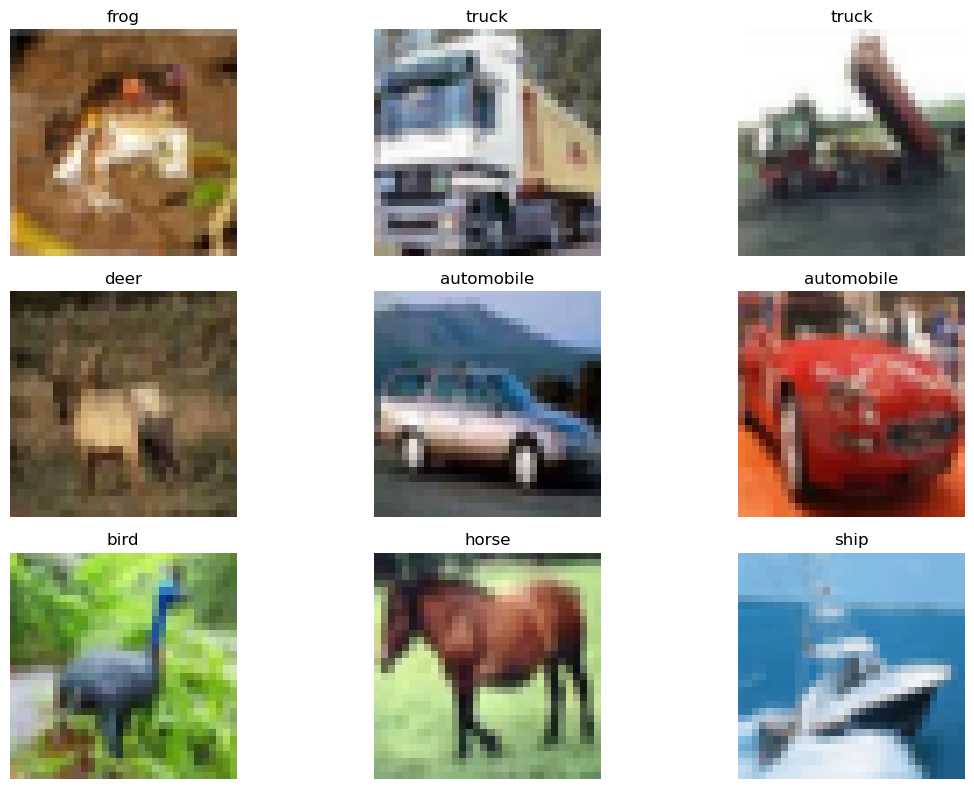

In [5]:
# Función para visualizar imágenes de muestra y sus etiquetas
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def plot_sample_images(x, y):
    plt.figure(figsize=(12, 8))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(np.clip(x[i], 0, 1))
        plt.title(class_names[np.argmax(y[i])])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualizar imágenes de muestra y sus etiquetas
plot_sample_images(x_train, y_train)

# Crea los generadores de datos
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)

datagen.fit(x_train)

In [6]:
# Define tu modelo
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compila y entrena el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(datagen.flow(x_train, y_train, batch_size=128), epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
391/391 [==============================] - 118s 297ms/step - loss: 1.8110 - accuracy: 0.3774 - val_loss: 2.5436 - val_accuracy: 0.2321
Epoch 2/5
391/391 [==============================] - 114s 293ms/step - loss: 1.3967 - accuracy: 0.4971 - val_loss: 1.1172 - val_accuracy: 0.6079
Epoch 3/5
391/391 [==============================] - 116s 297ms/step - loss: 1.2493 - accuracy: 0.5555 - val_loss: 1.0043 - val_accuracy: 0.6412
Epoch 4/5
391/391 [==============================] - 115s 294ms/step - loss: 1.1555 - accuracy: 0.5928 - val_loss: 1.0288 - val_accuracy: 0.6484
Epoch 5/5
391/391 [==============================] - 112s 287ms/step - loss: 1.0836 - accuracy: 0.6206 - val_loss: 1.4126 - val_accuracy: 0.5491


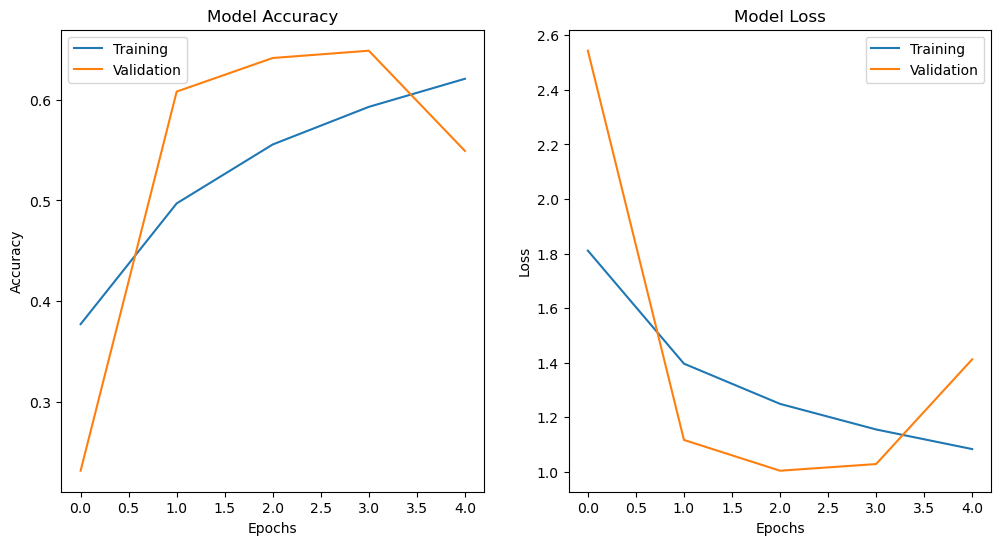

In [9]:
def plot_history(history):
    history_df = pd.DataFrame(history.history)
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history_df['accuracy'], label='Training')
    plt.plot(history_df['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_df['loss'], label='Training')
    plt.plot(history_df['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.savefig('training_validation_plots.png')
    plt.show()

# Call the plotting function to display the graphs
plot_history(history)

# Save the trained model
model.save('conv.h5')

### SAVE ARTIFACT IN S3

In [10]:
import boto3

# Nombre del archivo local y del bucket de S3
local_file_name = 'conv.h5'
s3_bucket_name = 'ml-en-produccion'

# Ruta en S3 donde deseas almacenar el archivo
s3_key = 'artifacts/conv.h5'

# Crea una instancia del cliente S3
s3_client = boto3.client('s3')

# Sube el archivo a S3
s3_client.upload_file(local_file_name, s3_bucket_name, s3_key)

print(f'Archivo {local_file_name} subido exitosamente a {s3_key} en el bucket {s3_bucket_name}.')

Archivo conv.h5 subido exitosamente a artifacts/conv.h5 en el bucket ml-en-produccion.
